In [2]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

In [138]:
# train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train/left/')
# test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test/left/')
train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train-v4/left/')
test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test-v2/left/')

In [137]:
images = list(train_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

151


(152, 152)


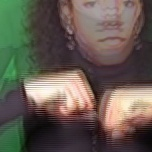

In [40]:
abitare = list(train_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(104, 104)


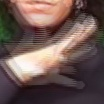

In [41]:
acqua = list(train_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [42]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[92, 96, 62, 64, 92, 94, 94, 116, 104, 86]

In [43]:
min(images_sizes)

50

In [44]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [45]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.025

In [46]:
np.round(np.mean(images_sizes))

100.0

In [124]:
batch_size = 10
img_height = 104
img_width = 104

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 231 files belonging to 10 classes.


Using 185 files for training.
Using 46 files for validation.


In [130]:
batch_size = 10
img_height = 104
img_width = 104

train_ds= tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 231 files belonging to 10 classes.


In [69]:
class_names = train_ds.class_names

In [119]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder_path,
  image_size=(img_height, img_width),
  batch_size=100)

Found 20 files belonging to 10 classes.


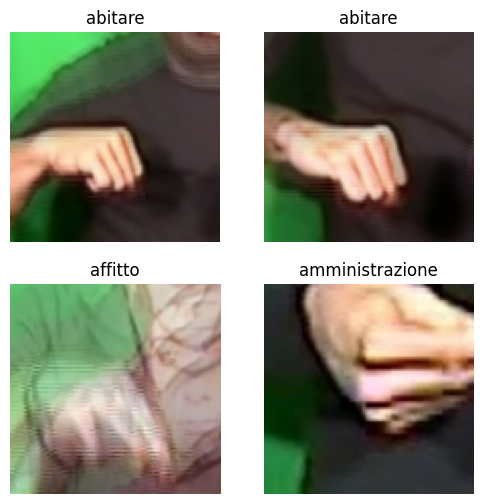

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [87]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

2.3264527 254.73466


In [106]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [88]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.009123345 0.99895954


In [125]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [131]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [132]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [133]:
model.fit(
  train_ds,
  epochs=10
)

Epoch 1/10


24/24 [==============================] - 2s 61ms/step - loss: 2.0226 - accuracy: 0.3247
Epoch 2/10
24/24 [==============================] - 1s 57ms/step - loss: 1.1067 - accuracy: 0.6494
Epoch 3/10
24/24 [==============================] - 1s 57ms/step - loss: 0.6552 - accuracy: 0.8009
Epoch 4/10
24/24 [==============================] - 1s 57ms/step - loss: 0.2773 - accuracy: 0.9221
Epoch 5/10
24/24 [==============================] - 2s 62ms/step - loss: 0.1278 - accuracy: 0.9610
Epoch 6/10
24/24 [==============================] - 2s 63ms/step - loss: 0.1252 - accuracy: 0.9524
Epoch 7/10
24/24 [==============================] - 1s 56ms/step - loss: 0.0452 - accuracy: 0.9913
Epoch 8/10
24/24 [==============================] - 1s 56ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 9/10
24/24 [==============================] - 1s 56ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/10
24/24 [==============================] - 1s 57ms/step - loss: 8.8399e-04 - accuracy: 1.0000


In [96]:
len(test_ds)

1

In [94]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']

In [134]:
x, y = next(iter(test_ds))
predictions = np.argmax(model.predict(x), axis=-1)
labels = y

m = tf.keras.metrics.Accuracy()
m.update_state(predictions, labels)
m.result().numpy()

1/1 [==============================] - 0s 84ms/step


0.85

Label: abbonamento
Prediction: abbonamento


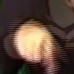




Label: abbonamento
Prediction: allegare


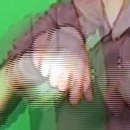




Label: abitare
Prediction: abitare


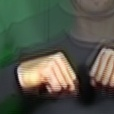




Label: abitare
Prediction: allergia


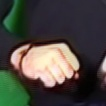




Label: acqua
Prediction: acqua


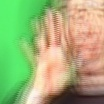




Label: acqua
Prediction: acqua


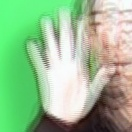




Label: affitto
Prediction: affitto


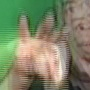




Label: affitto
Prediction: allergia


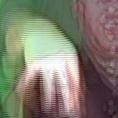




Label: allegare
Prediction: allegare


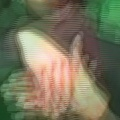




Label: allegare
Prediction: allegare


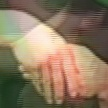




Label: allergia
Prediction: allergia


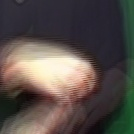




Label: allergia
Prediction: allergia


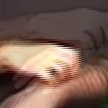




Label: ambulanza
Prediction: ambulanza


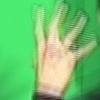




Label: ambulanza
Prediction: ambulanza


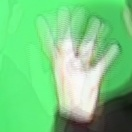




Label: amministrazione
Prediction: amministrazione


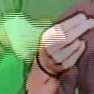




Label: amministrazione
Prediction: amministrazione


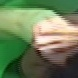




Label: ancona
Prediction: ancona


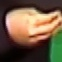




Label: ancona
Prediction: ancona


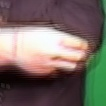




Label: andata
Prediction: acqua


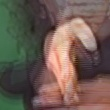




Label: andata
Prediction: ambulanza


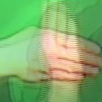

In [135]:
for path in test_folder_path.iterdir():
    for file in path.iterdir():
        print(f'Label: {path.name}')
        image = PIL.Image.open(file)
        image_array = tf.image.resize(image, [104,104])
        image_array = np.expand_dims(image_array, axis=0)
        print(f'Prediction: {class_names[int(np.argmax(model.predict(image_array, verbose=0)))]}')
        display(image)
        print('\n\n')
